The debiasing function used is implemented in the `RejectOptionClassification` class.
    * Statistical parity difference on the predictions of the classifier
    * Average odds difference for the classifier
    * Equal opportunity difference for the classifier

In [2]:
%pip install mlxtend pyECLAT efficient-apriori plotly matplotlib inline seaborn aif360
# Load all necessary packages
import sys
sys.path.append("../")
from collections import OrderedDict
import numpy as np
import pandas as pd
import seaborn as sns

from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder

Note: you may need to restart the kernel to use updated packages.


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


### Functions

In [3]:
# https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall

def compute_cl_metrics(dataset_true, dataset_pred,
                    disp = True):
    metrics = OrderedDict()
    metrics["Accuracy"] = accuracy_score(dataset_true.labels, dataset_pred.labels)
    metrics["Recall"] = recall_score(dataset_true.labels, dataset_pred.labels)
    metrics["Precision"] = precision_score(dataset_true.labels, dataset_pred.labels)
    metrics["Balanced accuracy"] = balanced_accuracy_score(dataset_true.labels, dataset_pred.labels)    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [4]:
def compute_fn_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
     
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [5]:
def plot_metrics(metrics_bef, metrics_aft): 
    df_metrics = pd.DataFrame({
        'Metric': list(metrics_bef.keys()),
        'Before': list(metrics_bef.values()),
        'After': list(metrics_aft.values())
    })

    df_metrics_melted = df_metrics.melt(id_vars='Metric', var_name='Stage', value_name='Value')
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_metrics_melted, x='Stage', y='Value', hue='Metric', marker='o')

    plt.ylabel('Metric Value')
    plt.title('Comparison of Metrics Before and After Applying ROC')
    plt.legend(title='Metric')
    plt.grid(True)
    plt.show()

In [6]:
def conf_matrix(dataset_true, dataset_pred):
    cm =confusion_matrix(dataset_true.labels, dataset_pred.labels)
    plt.figure(figsize=(3, 3))
    
    ConfusionMatrixDisplay(cm).plot()

In [7]:
def above_50k_graph(dataset):
    df_test = dataset.convert_to_dataframe()[0]
    df_above_50k = df_test[df_test['income'] == 1]
    df_above_50k

    # Count the number of male and female workers with income greater than 50K
    gender_counts = df_above_50k['sex'].value_counts()

    females_above_50k_count = gender_counts.get(0, 0) 
    total_count_above_50k = gender_counts.sum()
    print(f"Percentage of females earning over 50K: {females_above_50k_count/total_count_above_50k*100:.2f}%")
    print(f"Number of male workers earning over 50K: { gender_counts.get(1, 0)}")
    print(f"Total number of workers earning over 50K: {total_count_above_50k}")


    # Plotting the graph, the X axis gender should only contain 0 for female, 1 for male
    plt.figure(figsize=(5, 5))
    plt.bar(gender_counts.index, gender_counts.values, color=['lightblue', 'moccasin'])
    plt.xlabel('Gender')
    plt.xticks([0, 1], labels=['Female', 'Male'])
    plt.ylabel('Number of Workers')
    plt.title('Number of Male and Female Workers with Salary > 50K')
    plt.show()

In [8]:
def above_50k_graph_df(df):
    df_above_50k = df[df['income'] == 1]

    # Count the number of male and female workers with income greater than 50K
    gender_counts = df_above_50k['sex'].value_counts()

    females_above_50k_count = gender_counts.get(0, 0) 
    total_count_above_50k = gender_counts.sum()
    print(f"Percentage of females earning over 50K: {females_above_50k_count/total_count_above_50k*100:.2f}%")
    print(f"Number of male workers earning over 50K: { gender_counts.get(1, 0)}")
    print(f"Total number of workers earning over 50K: {total_count_above_50k}")

    # Plotting the graph, the X axis gender should only contain 0 for female, 1 for male
    plt.figure(figsize=(5, 5))
    plt.bar(gender_counts.index, gender_counts.values, color=['lightblue', 'moccasin'])
    plt.xlabel('Gender')
    plt.xticks([0, 1], labels=['Female', 'Male'])
    plt.ylabel('Number of Workers')
    plt.title('Number of Male and Female Workers with Salary > 50K')
    plt.show()

In [9]:

def plot_acc_vs_fairness(metric, metric_name, bal_acc_arr, thresh_arr_best_ind):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(class_thresh_arr, bal_acc_arr, color='b')
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14, labelcolor='b')
    ax2 = ax1.twinx()
    ax2.plot(thresh_arr, metric, color='r')
    ax2.set_ylabel(metric_name, color='r', fontsize=16, fontweight='bold')
    ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14, labelcolor='r')
    ax2.grid(True)

In [10]:
def group_edu(x):
    if x <= 5:
        return '<6'
    elif x >= 13:
        return '>12'
    else:
        return x

In [11]:
def age_cut(x):
    if x >= 70:
        return '>=70'
    else:
        return x

### Load dataset and specify options

In [12]:
# define the ML model
# Decision Tree, Logistic Regression
model = "Decision Tree"

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
target_variable = 'income'
sensible_attribute = 'sex'
        
# The debiasing function RejectOptionClassification accepts the following metrics:
    # Statistical parity difference on the predictions of the classifier
    # Average odds difference for the classifier
    # Equal opportunity difference for the classifier
metric_name = "Statistical parity difference"
        
#random seed for calibrated equal odds prediction
np.random.seed(1)

# Verify metric name
allowed_metrics = ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]
if metric_name not in allowed_metrics:
    raise ValueError("Metric name should be one of allowed metrics")

## Load and clean csv file

In [13]:
dataset_orig = pd.read_csv('dataset/adult.csv', header = 0)
print('shape before drop:',dataset_orig.shape)
dataset_orig.replace('?', np.nan, inplace=True)
dataset_orig.dropna(inplace=True)
# to_drop = ["workclass", "fnlwgt", "education", "capital-gain", "capital-loss", "hours-per-week"]

to_drop = ["fnlwgt", "education", "relationship", "workclass", "occupation"]
dataset_orig.drop(to_drop, axis=1, inplace=True)
dataset_orig_clean = dataset_orig.dropna()
print('shape after drop:',dataset_orig.shape)


shape before drop: (32561, 15)
shape after drop: (30162, 10)


In [14]:
# Categorical features are converted to numerical
dataset_orig_clean.loc[:, 'income'] = dataset_orig_clean['income'].map({
    '<=50K': 0,
    '>50K': 1
})
dataset_orig_clean['income'] = dataset_orig_clean['income'].astype(int)


dataset_orig_clean.loc[:, 'sex'] = dataset_orig_clean['sex'].map({
    'Female': 0,
    'Male': 1
})
dataset_orig_clean['sex'] = dataset_orig_clean['sex'].astype(int)

# 1 if married, 0 otherwise
dataset_orig_clean['marital.status'] = dataset_orig_clean['marital.status'].map({
    'Never-married': 0,
    'Divorced': 0,
    'Separated': 0,
    'Widowed': 0,
    'Married-civ-spouse': 1,
    'Married-spouse-absent': 1,
    'Married-AF-spouse': 1
})
dataset_orig_clean['marital.status'] = dataset_orig_clean['marital.status'].astype(int)


dataset_orig_clean['race'] = dataset_orig_clean['race'].apply(lambda x: 1 if x == 'White' else 0)
dataset_orig_clean['race'] = dataset_orig_clean['race'].astype(int)

# United-States is 0 all the other countries are 1
dataset_orig_clean['native.country'] = dataset_orig_clean['native.country'].apply(lambda x: 1 if x == 'United-States' else 0)
dataset_orig_clean['native.country'] = dataset_orig_clean['native.country'].astype(int)




In [15]:
dataset_orig_clean

,age,education.num,marital.status,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,9,0,1,0,0,4356,18,1,0
3,54,4,0,1,0,0,3900,40,1,0
4,41,10,0,1,0,0,3900,40,1,0
5,34,9,0,1,0,0,3770,45,1,0
6,38,6,0,1,1,0,3770,40,1,0
...,...,...,...,...,...,...,...,...,...,...
32556,22,10,0,1,1,0,0,40,1,0
32557,27,12,1,1,0,0,0,38,1,0
32558,40,9,1,1,1,0,0,40,1,1
32559,58,9,0,1,0,0,0,40,1,0


In [16]:
dataset_orig_clean.dtypes

age               int64
education.num     int64
marital.status    int64
race              int64
sex               int64
capital.gain      int64
capital.loss      int64
hours.per.week    int64
native.country    int64
income            int64
dtype: object

### Dataset visual

income
0    22654
1     7508
Name: count, dtype: int64


<Figure size 5000x5000 with 0 Axes>

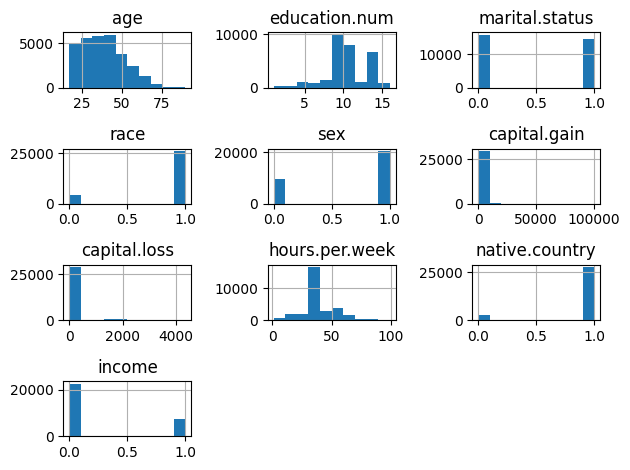

In [17]:
# what does the data look like now?
plt.figure(figsize=(50,50))

print(dataset_orig_clean['income'].value_counts())

# Plot the histogram of the dataset
dataset_orig_clean.hist()
plt.tight_layout()


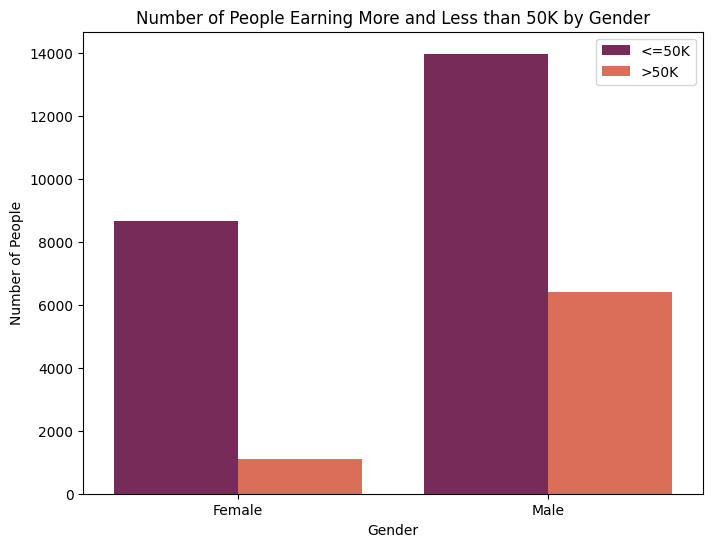

In [18]:
# Count the number of people earning more and less than 50K, divided by gender
income_gender_counts = dataset_orig_clean.groupby(['sex', 'income']).size().unstack()
# Plot the graph using seaborn
plt.figure(figsize=(8,6))
ax = sns.countplot(data=dataset_orig_clean, x='sex', hue='income', palette='rocket')
plt.xlabel('Gender')
plt.ylabel('Number of People')
plt.title('Number of People Earning More and Less than 50K by Gender')
plt.xticks([0, 1], labels=['Female', 'Male'], rotation=0)
plt.legend(['<=50K', '>50K'])
plt.show()

In [19]:
dataset = BinaryLabelDataset(
    df=dataset_orig_clean.copy(),
    label_names=['income'],
    favorable_label=1,
    unfavorable_label=0,
    protected_attribute_names=[sensible_attribute])

### Split into train and test

In [20]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_test = dataset.split([0.7], shuffle=True)

In [21]:
display(Markdown("#### Training & Test dimensions"))
print(dataset_orig_train.features.shape[0],",", dataset_orig_test.features.shape[0])

#### Training & Test dimensions

21113 , 9049


Percentage of females earning over 50K: 14.98%
Number of male workers earning over 50K: 4437
Total number of workers earning over 50K: 5219


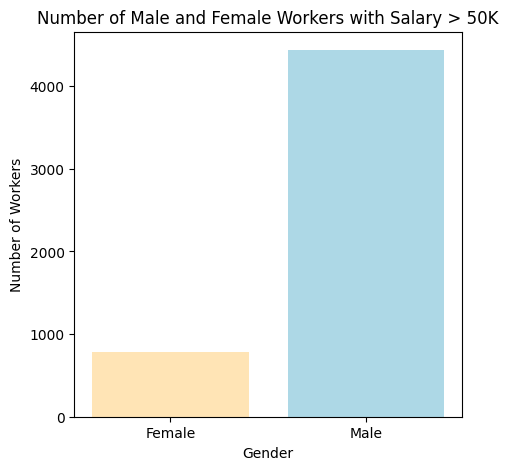

In [22]:
above_50k_graph(dataset_orig_train)

Percentage of females earning over 50K: 14.42%
Number of male workers earning over 50K: 1959
Total number of workers earning over 50K: 2289


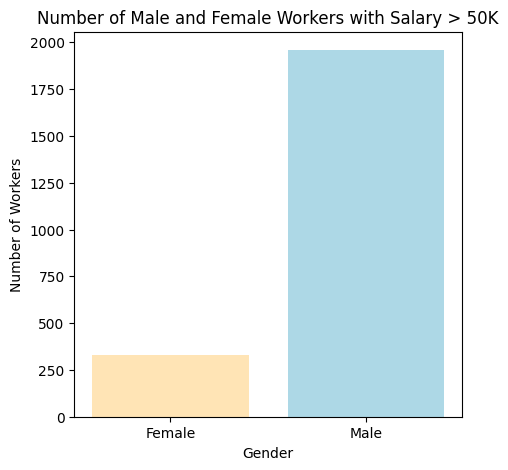

In [23]:
above_50k_graph(dataset_orig_test)

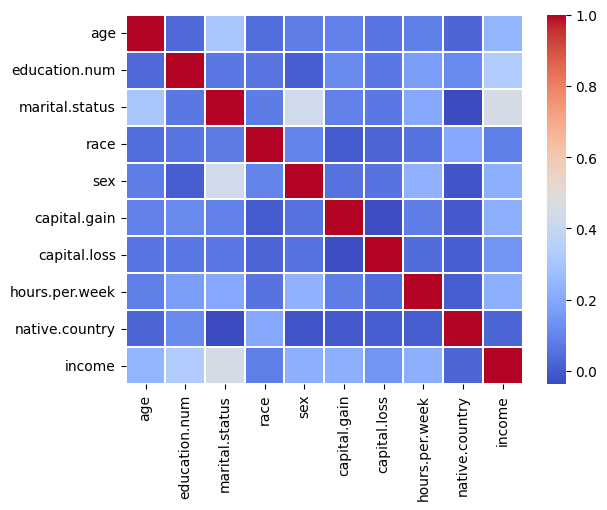

In [24]:
df_test = dataset_orig_test.convert_to_dataframe()[0]
g = sns.heatmap(df_test.corr(), annot=False, cmap="coolwarm", linewidths = 0.1)
plt.show()

#### Display properties of the training dataset

In [25]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(21113, 9)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'education.num', 'marital.status', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']


In [26]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Statistical Parity Difference or Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Statistical Parity Difference or Difference in mean outcomes between unprivileged and privileged groups = -0.196578


### Train classifier on original data

In [27]:
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

In [28]:
if model == "Decision Tree":
    model_instance = DecisionTreeClassifier(max_features=14,min_samples_leaf=100,random_state=10)
    model_instance.fit(X_train, y_train)
    y_train_pred = model_instance.predict(X_train)
elif model == "Logistic Regression":
    model_instance = LogisticRegression(random_state=101)
    model_instance.fit(X_train, y_train)
    y_train_pred = model_instance.predict(X_train)



# positive class index
pos_ind = np.where(model_instance.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_train_pred.labels = y_train_pred


Percentage of females earning over 50K: 11.87%
Number of male workers earning over 50K: 3505
Total number of workers earning over 50K: 3977


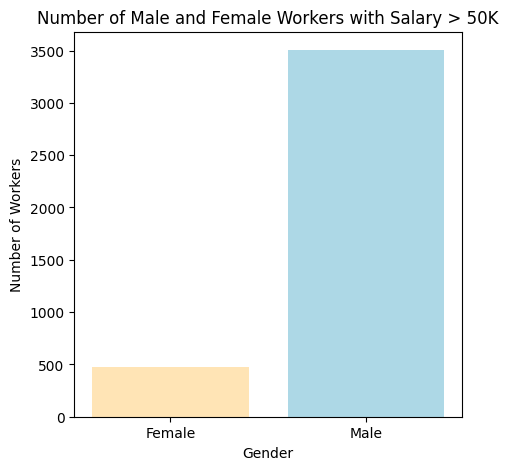

In [29]:
df_train_pred = dataset_orig_train_pred.copy(deepcopy=True)
df_train_pred.labels = df_train_pred.labels.reshape(-1, 1)
df_train_pred = df_train_pred.convert_to_dataframe()[0]


above_50k_graph_df(df_train_pred)


In [30]:
if model == "Decision Tree":
    print("Criterion:", model_instance.criterion)
    print("Depth:", model_instance.get_depth())
    print("Min samples per leaf:", model_instance.min_samples_leaf)
    print("Feature importances: ",list(zip(dataset_orig_train.feature_names, model_instance.feature_importances_)))


Criterion: gini
Depth: 14
Min samples per leaf: 100
Feature importances:  [('age', np.float64(0.06238730231097795)), ('education.num', np.float64(0.24985205796354795)), ('marital.status', np.float64(0.4093632003785486)), ('race', np.float64(0.0)), ('sex', np.float64(0.004117514955309507)), ('capital.gain', np.float64(0.20620801248042264)), ('capital.loss', np.float64(0.03225903250979686)), ('hours.per.week', np.float64(0.03577343401530113)), ('native.country', np.float64(3.94453860952947e-05))]


In [31]:
accuracy_score(dataset_orig_train.labels, dataset_orig_train_pred.labels)

0.8498555392412258

### Obtain scores for test set and find the optimal parameters from the test set

In [32]:
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = model_instance.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

#### Best threshold for classification only (no fairness)

if one label is more common than the other label, then the dataset is imbalanced -> balanced accuracy

0.5*(classified_metric_orig_test.true_positive_rate() + classified_metric_orig_test.true_negative_rate())

In [33]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_test_pred.scores > class_thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                             dataset_orig_test_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = balanced_accuracy_score(dataset_orig_test.labels, dataset_orig_test_pred.labels)

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))

print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.8105
Optimal classification threshold (no fairness constraints) = 0.2575


### Post-procesing technique

#### Estimate optimal parameters for the ROC method

In [34]:
# Upper and lower bound on the fairness metric used
metric_ub = 0.05
metric_lb = -0.05

In [35]:
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.1, high_class_thresh=0.9,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)
ROC = ROC.fit(dataset_orig_test, dataset_orig_test_pred)

In [36]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.2131
Optimal ROC margin = 0.1522


#### Predictions from Test Set

In [37]:
# Metrics for the test set
# if the probability of the positive class is greater than or equal to best_class_thresh, the sample will be classified as positive
fav_inds = dataset_orig_test_pred.scores > best_class_thresh
dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

display(Markdown("#### Test set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

metric_cl_test_bef = compute_cl_metrics(dataset_orig_test, dataset_orig_test_pred)
metric_fn_test_bef = compute_fn_metrics(dataset_orig_test, dataset_orig_test_pred, unprivileged_groups, privileged_groups)

#### Test set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Accuracy = 0.8025
Recall = 0.8266
Precision = 0.5765
Balanced accuracy = 0.8105
Statistical parity difference = -0.3681
Disparate impact = 0.2369
Average odds difference = -0.2466
Equal opportunity difference = -0.2399


<Figure size 300x300 with 0 Axes>

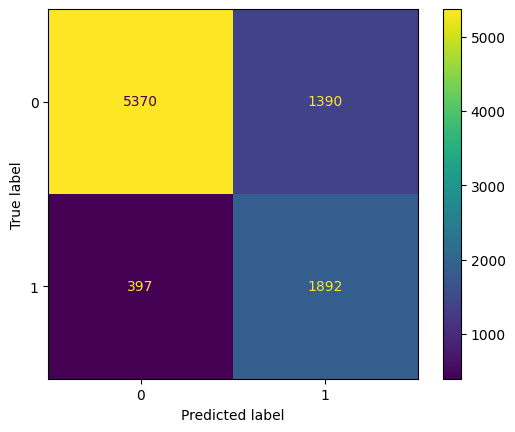

In [38]:
conf_matrix(dataset_orig_test, dataset_orig_test_pred)

Percentage of females earning over 50K: 10.24%
Number of male workers earning over 50K: 2946
Total number of workers earning over 50K: 3282


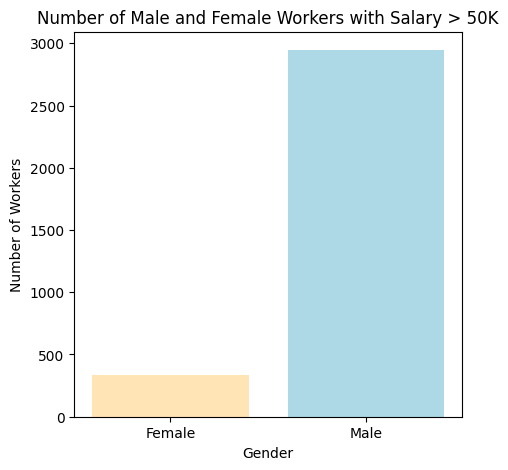

In [39]:
above_50k_graph(dataset_orig_test_pred)

#### ROC prediction

In [40]:
# Metrics for the transformed test set
dataset_transf_test_pred = ROC.predict(dataset_orig_test_pred)

display(Markdown("#### Test set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_cl_test_aft = compute_cl_metrics(dataset_orig_test, dataset_transf_test_pred)
metric_fn_test_aft = compute_fn_metrics(dataset_orig_test, dataset_transf_test_pred, 
                unprivileged_groups, privileged_groups)

#### Test set

##### Transformed predictions - With fairness constraints

Accuracy = 0.7901
Recall = 0.7671
Precision = 0.5625
Balanced accuracy = 0.7825
Statistical parity difference = -0.0497
Disparate impact = 0.8624
Average odds difference = 0.1105
Equal opportunity difference = 0.1659


<Figure size 300x300 with 0 Axes>

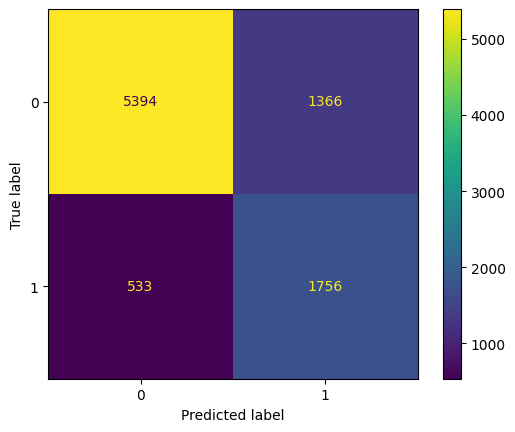

In [41]:
conf_matrix(dataset_orig_test, dataset_transf_test_pred)

Percentage of females earning over 50K: 29.34%
Number of male workers earning over 50K: 2206
Total number of workers earning over 50K: 3122


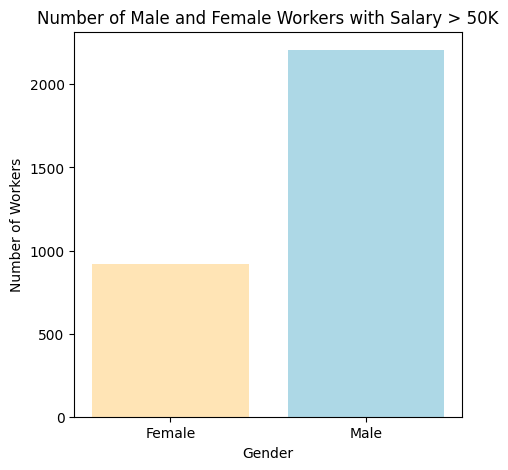

In [42]:
above_50k_graph(dataset_transf_test_pred)

### Evaluation Metrics For Classification Model and Fairness

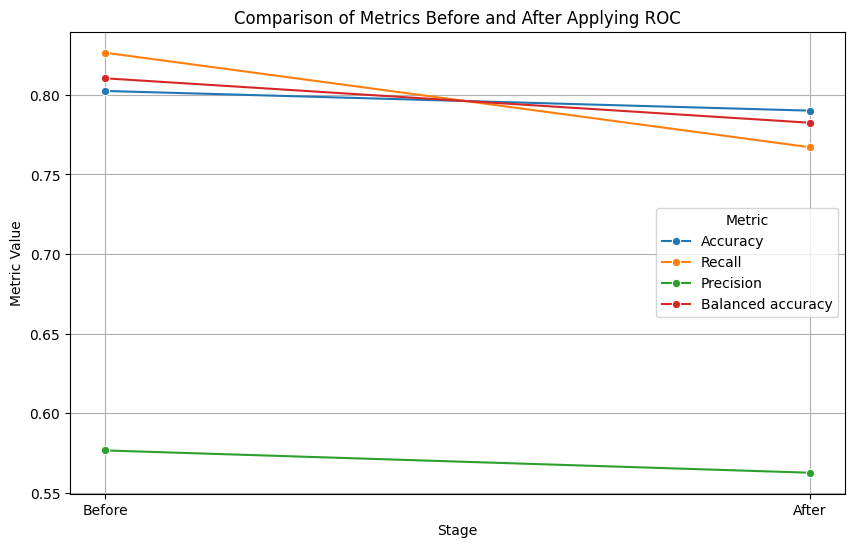

In [43]:
plot_metrics(metric_cl_test_bef, metric_cl_test_aft)

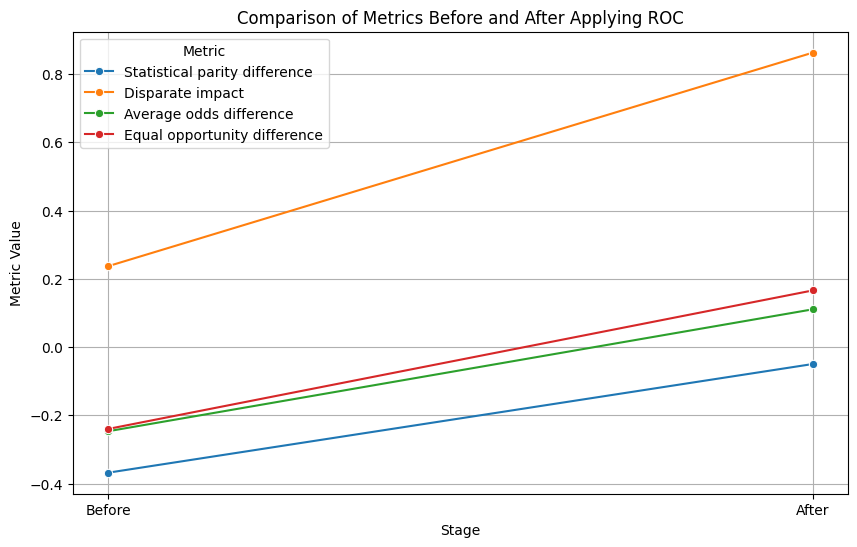

In [44]:
plot_metrics(metric_fn_test_bef, metric_fn_test_aft)

In [45]:
df_metrics = pd.DataFrame({
    'Metric': list(metric_fn_test_bef.keys()),
    'Before': list(metric_fn_test_bef.values()),
    'After': list(metric_fn_test_aft.values())
})

# Calculate the percentage change
df_metrics['Percentage Change'] = ((df_metrics['After'] - df_metrics['Before']) / df_metrics['Before']) * 100
df_metrics['Percentage Change'] = df_metrics['Percentage Change'].apply(lambda x: f"{x:.2f}%")
df_metrics

,Metric,Before,After,Percentage Change
0,Statistical parity difference,-0.368071,-0.049707,-86.50%
1,Disparate impact,0.236870,0.862371,264.07%
2,Average odds difference,-0.246608,0.110507,-144.81%
3,Equal opportunity difference,-0.239942,0.165855,-169.12%


## Association rules

- Support: The proportion of transactions in the dataset where both antecedent and consequent are present.
    - Measures how frequently a rule is observed in the dataset.
- Confidence: The ratio of the number of times both antecedent and consequent occur together to the number of times the antecedent occurs.
    - Represents how often the rule is true.

**FP-GROWTH**

Compress a large database into a compact, Frequent-Pattern tree (FP-tree) structure.

Datasets are encoded using a compact structure, the FP-tree.

Frequent itemsets are extracted directly from the FP-tree.

***GOAL*** To avoid candidate generation (computationally expensive)

Main steps:

    1. Construct the frequent pattern tree
    2. For each frequent item: compute the projected FP-tree
    3. Mine conditional FP-trees and grow frequent patterns
    4. If the conditional FP-tree contains a single path: enumerate all the patterns


In [46]:
def compute_and_print_association_rules(dataset, min_support, min_confidence):
    # Convert the dataset to a DataFrame
    pd_converted = dataset.convert_to_dataframe()[0]

    # Process 'sex' column
    pd_converted['male'] = pd_converted['sex'].apply(lambda x: 1 if x == 1 else 0)
    pd_converted['female'] = pd_converted['sex'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='sex', inplace=True)

    # Process 'race' column
    pd_converted['nwhite'] = pd_converted['race'].apply(lambda x: 1 if x == 1 or x==2 else 0)
    pd_converted['white'] = pd_converted['race'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='race', inplace=True)

    # Process 'income' column
    pd_converted['>50K'] = pd_converted['income'].apply(lambda x: 1 if x == 1 else 0)
    pd_converted['<50K'] = pd_converted['income'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='income', inplace=True)

    pd_converted['Age (decade)'] = pd_converted['age'].apply(lambda x: x//10*10)
    pd_converted = pd_converted.drop(columns='age')

    pd_converted = pd.get_dummies(pd_converted)

    # Create a binary representation of transactions
    df_transactions = pd_converted.map(lambda x: True if x > 0 else False)

    # Apply FP-growth algorithm to find frequent itemsets
    frequent_itemsets = fpgrowth(df_transactions, min_support=min_support, use_colnames=True)

    # Extract association rules with min confidence
    res = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

    # Filter rules with consequents '<=50K' and '>50K'
    res_min50 = res[res['consequents'] == {'<50K'}]
    res_max50 = res[res['consequents'] == {'>50K'}]

    
    return(res_min50,res_max50)

    # Print sorted results
    # print("Rules with consequents '<=50K':")
    # print(res_min50.sort_values("confidence", ascending=False))

    # print("\nRules with consequents '>50K':")
    # print(res_max50.sort_values("confidence", ascending=False))

In [47]:
def asso_rules(dataset, min_support, min_confidence):
    # Convert the dataset to a DataFrame
    pd_converted = dataset.convert_to_dataframe()[0]

    # one hot encoding
    pd_converted = pd.get_dummies(pd_converted)

    # Create a binary representation of transactions
    df_transactions = pd_converted.map(lambda x: True if x > 0 else False)

    # Apply FP-growth algorithm to find frequent itemsets
    frequent_itemsets = fpgrowth(df_transactions, min_support=min_support, use_colnames=True)

    # Extract association rules with min confidence
    res = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

    # Filter rules with consequents '<=50K' and '>50K'
    res_min50 = res[res['consequents'] == {'<50K'}]
    res_max50 = res[res['consequents'] == {'>50K'}]

    
    return(res_min50,res_max50)

    # Print sorted results
    # print("Rules with consequents '<=50K':")
    # print(res_min50.sort_values("confidence", ascending=False))

    # print("\nRules with consequents '>50K':")
    # print(res_max50.sort_values("confidence", ascending=False))

In [48]:
def income_association_rules(dataset, min_support=0.2, min_confidence=0.5):
    # Convert the dataset to a DataFrame
    pd_converted = dataset.convert_to_dataframe()[0]

    # Create a binary representation of transactions
    df_transactions = pd_converted.map(lambda x: True if x > 0 else False)

    # Apply FP-growth algorithm to find frequent itemsets
    frequent_itemsets = fpgrowth(df_transactions, min_support=min_support, use_colnames=True)

    # Extract association rules with min confidence
    res = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

    # Filter rules with consequents '<=50K' and '>50K'
    res_min50 = res[res['consequents'] == {'0'}]
    res_max50 = res[res['consequents'] == {'1'}]

    
    return(res_min50,res_max50)

In [51]:
res_min50_test,res_max50_test = asso_rules(dataset_orig_test, min_support=0.4, min_confidence=0.4)
res_min50_test.sort_values("confidence", ascending=False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


In [62]:
# Convert the dataset to a DataFrame
pd_converted = dataset.convert_to_dataframe()[0]

# Education number from 0 to 5 are put in '<6' and those above 13 into '>12'
pd_converted['education.num'] = pd_converted['education.num'].apply(lambda x: group_edu(x))
pd_converted['education.num'] = pd_converted['education.num'].astype(str)
# Group age by decade
pd_converted['Age (decade)'] = pd_converted['age'].apply(lambda x: x//10*10)
pd_converted = pd_converted.drop(columns='age')
# Group hours per week
pd_converted['hours.per.week'] = pd_converted['hours.per.week'].apply(lambda x: '>40' if x > 40 else '<=40')



# Capital gain is splitted into two columns capital.gain>0 and capital.gain=0
pd_converted['capital.gain>0'] = pd_converted['capital.gain'].apply(lambda x: 1 if x > 0 else 0)
pd_converted['capital.gain=0'] = pd_converted['capital.gain'].apply(lambda x: 1 if x == 0 else 0)
pd_converted.drop(columns='capital.gain', inplace=True)

# Capital loss is splitted into two columns capital.loss>0 and capital.loss=0
pd_converted['capital.loss>0'] = pd_converted['capital.loss'].apply(lambda x: 1 if x > 0 else 0)
pd_converted['capital.loss=0'] = pd_converted['capital.loss'].apply(lambda x: 1 if x == 0 else 0)
pd_converted.drop(columns='capital.loss', inplace=True)


pd_converted['male'] = pd_converted['sex'].apply(lambda x: 1 if x == 1 else 0)
pd_converted['female'] = pd_converted['sex'].apply(lambda x: 1 if x == 0 else 0)
pd_converted.drop(columns='sex', inplace=True) 

# Process 'race' column
pd_converted['white'] = pd_converted['race'].apply(lambda x: 1 if x == 1 else 0)
pd_converted['n_white'] = pd_converted['race'].apply(lambda x: 1 if x == 0 else 0)
pd_converted.drop(columns='race', inplace=True)

# Process 'income' column
pd_converted['>50K'] = pd_converted['income'].apply(lambda x: 1 if x == 1 else 0)
pd_converted['<50K'] = pd_converted['income'].apply(lambda x: 1 if x == 0 else 0)
pd_converted.drop(columns='income', inplace=True)

# 1 if married, 0 otherwise
pd_converted['married'] = pd_converted['marital.status'].apply(lambda x: 1 if x == 1 else 0)
pd_converted['n_married'] = pd_converted['marital.status'].apply(lambda x: 1 if x == 0 else 0)
pd_converted.drop(columns='marital.status', inplace=True)

# United-States is 1 all the other countries are 0
pd_converted['UnitedStates'] = pd_converted['native.country'].apply(lambda x: 1 if x == 1 else 0)
pd_converted['n_UnitedStates'] = pd_converted['native.country'].apply(lambda x: 1 if x == 0 else 0)
pd_converted.drop(columns='native.country', inplace=True)

In [63]:
pd_converted = pd.get_dummies(pd_converted,columns=['education.num','Age (decade)', 'hours.per.week'],drop_first=False)


In [64]:
pd_converted

,capital.gain>0,capital.gain=0,capital.loss>0,capital.loss=0,male,female,white,n_white,>50K,<50K,...,education.num_>12,Age (decade)_10.0,Age (decade)_20.0,Age (decade)_30.0,Age (decade)_40.0,Age (decade)_50.0,Age (decade)_60.0,Age (decade)_70.0,Age (decade)_80.0,Age (decade)_90.0
1,0,1,1,0,0,1,1,0,0,1,...,False,False,False,False,False,False,False,False,True,False
3,0,1,1,0,0,1,1,0,0,1,...,False,False,False,False,False,True,False,False,False,False
4,0,1,1,0,0,1,1,0,0,1,...,False,False,False,False,True,False,False,False,False,False
5,0,1,1,0,0,1,1,0,0,1,...,False,False,False,True,False,False,False,False,False,False
6,0,1,1,0,1,0,1,0,0,1,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,1,0,1,1,0,1,0,0,1,...,False,False,True,False,False,False,False,False,False,False
32557,0,1,0,1,0,1,1,0,0,1,...,False,False,True,False,False,False,False,False,False,False
32558,0,1,0,1,1,0,1,0,1,0,...,False,False,False,False,True,False,False,False,False,False
32559,0,1,0,1,0,1,1,0,0,1,...,False,False,False,False,False,True,False,False,False,False


In [65]:
# Create a binary representation of transactions
df_transactions = pd_converted.map(lambda x: True if x > 0 else False)
df_transactions

,capital.gain>0,capital.gain=0,capital.loss>0,capital.loss=0,male,female,white,n_white,>50K,<50K,...,education.num_>12,Age (decade)_10.0,Age (decade)_20.0,Age (decade)_30.0,Age (decade)_40.0,Age (decade)_50.0,Age (decade)_60.0,Age (decade)_70.0,Age (decade)_80.0,Age (decade)_90.0
1,False,True,True,False,False,True,True,False,False,True,...,False,False,False,False,False,False,False,False,True,False
3,False,True,True,False,False,True,True,False,False,True,...,False,False,False,False,False,True,False,False,False,False
4,False,True,True,False,False,True,True,False,False,True,...,False,False,False,False,True,False,False,False,False,False
5,False,True,True,False,False,True,True,False,False,True,...,False,False,False,True,False,False,False,False,False,False
6,False,True,True,False,True,False,True,False,False,True,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,False,True,False,True,True,False,True,False,False,True,...,False,False,True,False,False,False,False,False,False,False
32557,False,True,False,True,False,True,True,False,False,True,...,False,False,True,False,False,False,False,False,False,False
32558,False,True,False,True,True,False,True,False,True,False,...,False,False,False,False,True,False,False,False,False,False
32559,False,True,False,True,False,True,True,False,False,True,...,False,False,False,False,False,True,False,False,False,False


In [66]:
# Apply FP-growth algorithm to find frequent itemsets
frequent_itemsets = fpgrowth(df_transactions, min_support=0.5, use_colnames=True)

# Extract association rules with min confidence
res = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Filter rules with consequents '<=50K' and '>50K'
res_min50 = res[res['consequents'] == {'<50K'}]
res_max50 = res[res['consequents'] == {'>50K'}]


In [69]:
# export res to a csv file
res.to_csv('association_rules.csv', index=False)


In [67]:
res_max50.sort_values("confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


In [68]:
res_min50.sort_values("confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
59,"(capital.loss=0, capital.gain=0)",(<50K),0.868543,0.751078,0.696937,0.802420,1.068359,0.044593,1.259857,0.486736
78,"(capital.loss=0, UnitedStates, capital.gain=0)",(<50K),0.789603,0.751078,0.630230,0.798161,1.062688,0.037177,1.233272,0.280374
110,"(capital.loss=0, white, capital.gain=0)",(<50K),0.742192,0.751078,0.585836,0.789333,1.050934,0.028393,1.181590,0.187989
51,(capital.gain=0),(<50K),0.915854,0.751078,0.719813,0.785947,1.046426,0.031935,1.162901,0.527255
153,"(capital.loss=0, white, UnitedStates, capital....",(<50K),0.690803,0.751078,0.541841,0.784364,1.044318,0.022994,1.154362,0.137249
66,"(UnitedStates, capital.gain=0)",(<50K),0.833665,0.751078,0.651449,0.781428,1.040409,0.025302,1.138857,0.233501
92,"(white, capital.gain=0)",(<50K),0.784696,0.751078,0.605895,0.772140,1.028042,0.016527,1.092434,0.126693
125,"(UnitedStates, white, capital.gain=0)",(<50K),0.731649,0.751078,0.561037,0.766812,1.020949,0.011512,1.067474,0.076463
56,(capital.loss=0),(<50K),0.952689,0.751078,0.728201,0.764364,1.017690,0.012658,1.056386,0.367406
71,"(capital.loss=0, UnitedStates)",(<50K),0.867814,0.751078,0.658743,0.759083,1.010659,0.006947,1.033230,0.079784


In [64]:
res_min50_test,res_max50_test = compute_and_print_association_rules(dataset_orig_test, min_support=0.5, min_confidence=0.7)
res_min50_test.sort_values("confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
391,(education.num),(<50K),1.000000,0.747044,0.747044,0.747044,1.000000,0.000000,1.000000,0.000000
393,(hours.per.week),(<50K),1.000000,0.747044,0.747044,0.747044,1.000000,0.000000,1.000000,0.000000
395,(Age (decade)),(<50K),1.000000,0.747044,0.747044,0.747044,1.000000,0.000000,1.000000,0.000000
407,"(hours.per.week, Age (decade))",(<50K),1.000000,0.747044,0.747044,0.747044,1.000000,0.000000,1.000000,0.000000
401,"(education.num, hours.per.week)",(<50K),1.000000,0.747044,0.747044,0.747044,1.000000,0.000000,1.000000,0.000000
419,"(education.num, Age (decade), hours.per.week)",(<50K),1.000000,0.747044,0.747044,0.747044,1.000000,0.000000,1.000000,0.000000
413,"(education.num, Age (decade))",(<50K),1.000000,0.747044,0.747044,0.747044,1.000000,0.000000,1.000000,0.000000
443,"(native.country, education.num)",(<50K),0.914576,0.747044,0.679965,0.743475,0.995223,-0.003264,0.986088,-0.053202
397,(native.country),(<50K),0.914576,0.747044,0.679965,0.743475,0.995223,-0.003264,0.986088,-0.053202
433,"(native.country, Age (decade))",(<50K),0.914576,0.747044,0.679965,0.743475,0.995223,-0.003264,0.986088,-0.053202


In [50]:
res_max50_test.sort_values("confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


### Test predicions rules matching

In [51]:
df_test_pred = dataset_orig_test_pred.convert_to_dataframe()[0]
# Process 'sex' column
df_test_pred['male'] = df_test_pred['sex'].apply(lambda x: 1 if x == 1 else 0)
df_test_pred['female'] = df_test_pred['sex'].apply(lambda x: 1 if x == 0 else 0)
df_test_pred.drop(columns='sex', inplace=True)

# Process 'race' column
df_test_pred['white'] = df_test_pred['race'].apply(lambda x: 1 if x == 1 else 0)
df_test_pred['nwhite'] = df_test_pred['race'].apply(lambda x: 1 if x == 0 else 0)
df_test_pred.drop(columns='race', inplace=True)

# Process 'income' column
df_test_pred['>50K'] = df_test_pred['income'].apply(lambda x: 1 if x == 1 else 0)
df_test_pred['<50K'] = df_test_pred['income'].apply(lambda x: 1 if x == 0 else 0)
df_test_pred.drop(columns='income', inplace=True)

# Create a binary representation of transactions
df_transactions_test_pred= df_test_pred.map(lambda x: True if x > 0 else False)

In [52]:
results = []

# for each association rule, check how many rows of dataset_transf_test_pred met it
for index, rule in res_min50_test.iterrows():
    antecedents = list(rule['antecedents'])
    matching_rows = df_transactions_test_pred.copy()
    for antecedent in antecedents:
        matching_rows = matching_rows[matching_rows[antecedent] == True]
    
    consequent = list(rule['consequents'])[0]
    consequent_met = matching_rows[matching_rows[consequent] == True]
    
    total_matching = len(matching_rows)
    total_consequent_met = len(consequent_met)
    
    rule_result = {
        'Rule': f"{set(rule['antecedents'])} -> {set(rule['consequents'])}".replace("frozenset({", "").replace("})", ""),
        'Number of conseq matching': total_consequent_met,
        'Respecting the rule before roc': f"{round(total_consequent_met / total_matching * 100, 2)}%" if total_matching > 0 else "0%",
    }
    
    results.append(rule_result)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
display(results_df)

""


Percentage of different labels: 14.59%


/tmp/ipykernel_5796/3626160822.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_diff, palette='viridis')


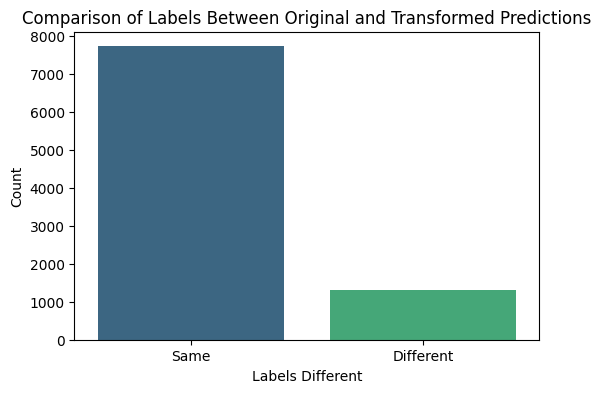

In [53]:
# Convert datasets to DataFrames
df_orig_test_pred = dataset_orig_test_pred.convert_to_dataframe()[0]
df_transf_test_pred = dataset_transf_test_pred.convert_to_dataframe()[0]

# Compare the labels
label_diff = df_orig_test_pred['income'] != df_transf_test_pred['income']

# Calculate the percentage of different labels
diff_percentage = label_diff.mean() * 100
print(f"Percentage of different labels: {diff_percentage:.2f}%")

# Visualize the differences
plt.figure(figsize=(6, 4))
sns.countplot(x=label_diff, palette='viridis')
plt.xlabel('Labels Different')
plt.ylabel('Count')
plt.title('Comparison of Labels Between Original and Transformed Predictions')
plt.xticks([0, 1], labels=['Same', 'Different'])
plt.show()

### Post ROC rules matching

In [54]:
df_post_roc = dataset_transf_test_pred.convert_to_dataframe()[0]
# Process 'sex' column
df_post_roc['male'] = df_post_roc['sex'].apply(lambda x: 1 if x == 1 else 0)
df_post_roc['female'] = df_post_roc['sex'].apply(lambda x: 1 if x == 0 else 0)
df_post_roc.drop(columns='sex', inplace=True)

# Process 'race' column
df_post_roc['white'] = df_post_roc['race'].apply(lambda x: 1 if x == 1 else 0)
df_post_roc['nwhite'] = df_post_roc['race'].apply(lambda x: 1 if x == 0 else 0)
df_post_roc.drop(columns='race', inplace=True)

# Process 'income' column
df_post_roc['>50K'] = df_post_roc['income'].apply(lambda x: 1 if x == 1 else 0)
df_post_roc['<50K'] = df_post_roc['income'].apply(lambda x: 1 if x == 0 else 0)
df_post_roc.drop(columns='income', inplace=True)

# Create a binary representation of transactions
df_transactions_roc = df_post_roc.map(lambda x: True if x > 0 else False)

In [55]:
results_roc = []

# for each association rule, check how many rows of dataset_transf_test_pred met it
for index, rule in res_min50_test.iterrows():
    antecedents = list(rule['antecedents'])
    matching_rows = df_transactions_roc.copy()
    for antecedent in antecedents:
        matching_rows = matching_rows[matching_rows[antecedent] == True]
    
    consequent = list(rule['consequents'])[0]
    consequent_met = matching_rows[matching_rows[consequent] == True]
    
    total_matching = len(matching_rows)
    total_consequent_met = len(consequent_met)
    
    rule_result = {
        'Rule': f"{set(rule['antecedents'])} -> {set(rule['consequents'])}".replace("frozenset({", "").replace("})", ""),
        'Number of conseq matching': total_consequent_met,
        'Respecting the rule after roc': f"{round(total_consequent_met / total_matching * 100, 2)}%" if total_matching > 0 else "0%",
    }
    
    results_roc.append(rule_result)

# Create a DataFrame to display the results
results_roc_df = pd.DataFrame(results_roc)
display(results_roc_df)



""


In [56]:
res_min50,res_max50 = compute_and_print_association_rules(dataset_transf_test_pred, min_support=0.2, min_confidence=0.9)
res_min50.sort_values("confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


In [57]:
# Calculate association rules for the original test dataset
res_min50_orig, res_max50_orig = compute_and_print_association_rules(dataset_orig_test, min_support=0.2, min_confidence=0.5)

# Calculate association rules for the transformed test dataset
res_min50_transf, res_max50_transf = compute_and_print_association_rules(dataset_transf_test_pred, min_support=0.2, min_confidence=0.5)

# Function to calculate and print the number of rules kept, not kept, and newly introduced
def compare_rules(res_orig, res_transf, consequent):
    rules_kept = set(res_orig['antecedents']).intersection(set(res_transf['antecedents']))
    rules_not_kept = set(res_orig['antecedents']).difference(set(res_transf['antecedents']))
    new_rules = set(res_transf['antecedents']).difference(set(res_orig['antecedents']))

    print(f"Number of association rules with consequents '{consequent}' kept: {len(rules_kept)}")
    print(f"Number of association rules with consequents '{consequent}' not kept: {len(rules_not_kept)}")
    print(f"Number of new association rules with consequents '{consequent}': {len(new_rules)}")

    print(f"\nRules with consequents '{consequent}' kept:")
    for rule in rules_kept:
        print(rule)

    print(f"\nRules with consequents '{consequent}' not kept:")
    for rule in rules_not_kept:
        print(rule)

    print(f"\nNew rules with consequents '{consequent}':")
    for rule in new_rules:
        print(rule)

# Compare rules for '<=50K'
compare_rules(res_min50_orig, res_min50_transf, '<=50K')

Number of association rules with consequents '<=50K' kept: 39
Number of association rules with consequents '<=50K' not kept: 40
Number of new association rules with consequents '<=50K': 0

Rules with consequents '<=50K' kept:
frozenset({'age', 'hours.per.week', 'white', 'education.num'})
frozenset({'age', 'female', 'education.num'})
frozenset({'age', 'education.num'})
frozenset({'education.num'})
frozenset({'education.num', 'age', 'white', 'male'})
frozenset({'education.num', 'age', 'male'})
frozenset({'age', 'female', 'education.num', 'hours.per.week'})
frozenset({'age', 'white', 'education.num'})
frozenset({'white', 'male'})
frozenset({'hours.per.week', 'white', 'male'})
frozenset({'education.num', 'age', 'hours.per.week', 'male'})
frozenset({'white'})
frozenset({'hours.per.week'})
frozenset({'age', 'female'})
frozenset({'age'})
frozenset({'hours.per.week', 'female'})
frozenset({'age', 'male'})
frozenset({'male'})
frozenset({'age', 'hours.per.week', 'education.num'})
frozenset({'hour